In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import ta

In [34]:
# Load CSV data
data_path = 'data.csv'
data = pd.read_csv(data_path)

In [35]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [39]:
# Compute Indicators
def compute_indicators(data):
    data['EMAf'] = ta.trend.ema_indicator(data['close'], 10)
    data['EMAs'] = ta.trend.ema_indicator(data['close'], 30)
    data['Trend'] = ta.trend.sma_indicator(data['close'], 50)
    data['RSI'] = ta.momentum.rsi(data['close'])
    data['ATR'] = ta.volatility.average_true_range(data['high'], data['low'], data['close'], window=14)
    data['CCI'] = ta.trend.cci(data['high'], data['low'], data['close'], window=14)
    data['MACD'] = ta.trend.macd(data['close'])
    data['OBV'] = ta.volume.on_balance_volume(data['close'], data['volume'])
    data['Williams %R'] = ta.momentum.williams_r(data['high'], data['low'], data['close'], lbp=14)
    data['KAMA'] = ta.momentum.kama(data['close'], window=10, pow1=2, pow2=30)
    return data

data = compute_indicators(data)

In [40]:
# Drop NANs
data.dropna(inplace=True)
data.head()

,open,high,low,close,volume,EMAf,EMAs,Trend,RSI,ATR,CCI,MACD,OBV,Williams %R,KAMA
date,,,,,,,,,,,,,,,
2019-11-29 08:00:00,152.51,153.18,152.06,152.17,5413.910,151.961056,151.517658,150.5750,52.761657,1.743891,77.142441,0.283015,-6978.630,-35.742188,152.389181
2019-11-29 09:00:00,152.17,154.88,152.17,154.37,4537.590,152.399045,151.701680,150.7424,61.384710,1.812899,228.276055,0.455690,-2441.040,-8.500000,152.718057
2019-11-29 10:00:00,154.37,155.13,153.52,154.00,8070.640,152.690128,151.849958,151.1624,59.420156,1.798406,213.239921,0.556268,-10511.680,-18.080000,152.812182
2019-11-29 11:00:00,154.00,154.34,153.14,153.26,6056.583,152.793741,151.940929,151.5676,55.588361,1.755663,120.813179,0.569698,-16568.263,-29.920000,152.830285
2019-11-29 12:00:00,153.26,155.15,151.09,154.56,10224.940,153.114879,152.109901,151.8064,60.417484,1.920259,98.344617,0.677431,-6343.323,-9.409888,152.997670


In [41]:
# Normalize data
scaler = MinMaxScaler()
columns_to_normalize = ['open','close','high','low','EMAf','EMAs','Trend','RSI','ATR','CCI','MACD','OBV','Williams %R','KAMA']
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

In [42]:
# Create Sequences
def create_sequences(data, sequence_length):
    xs = []
    ys = []

    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length]
        y = data.iloc[i+sequence_length, 3] # Use iloc to access the element by position
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

sequence_length = 100
features = data[['open', 'close', 'high', 'low', 'EMAf', 'EMAs', 'Trend', 'RSI', 'ATR', 'CCI', 'MACD', 'OBV', 'Williams %R', 'KAMA']]
X, y = create_sequences(features, sequence_length)

In [43]:
# Load the saved model
model_save_path = 'best_model.keras'
model = load_model(model_save_path)

In [44]:
# Make predictions
predictions = model.predict(X)

1245/1245 [==============================] - 97s 77ms/step


In [47]:
# Rescale predictions
predictions_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((predictions.shape[0], len(columns_to_normalize) - 1)), predictions], axis=1)
)[:, -1]
y_rescaled = scaler.inverse_transform(
    np.concatenate([np.zeros((len(y), len(columns_to_normalize) - 1)), y.reshape(-1, 1)], axis=1)
)[:, -1]

In [48]:
# Calculate metrics
mse = mean_squared_error(y_rescaled, predictions_rescaled)
r2 = r2_score(y_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_rescaled, predictions_rescaled)

In [49]:
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
print(f"MAE: {mae}")

MSE: 389.82770382391226
RMSE: 19.744054898219673
R2: 0.999697038436955
MAE: 11.745944453367061


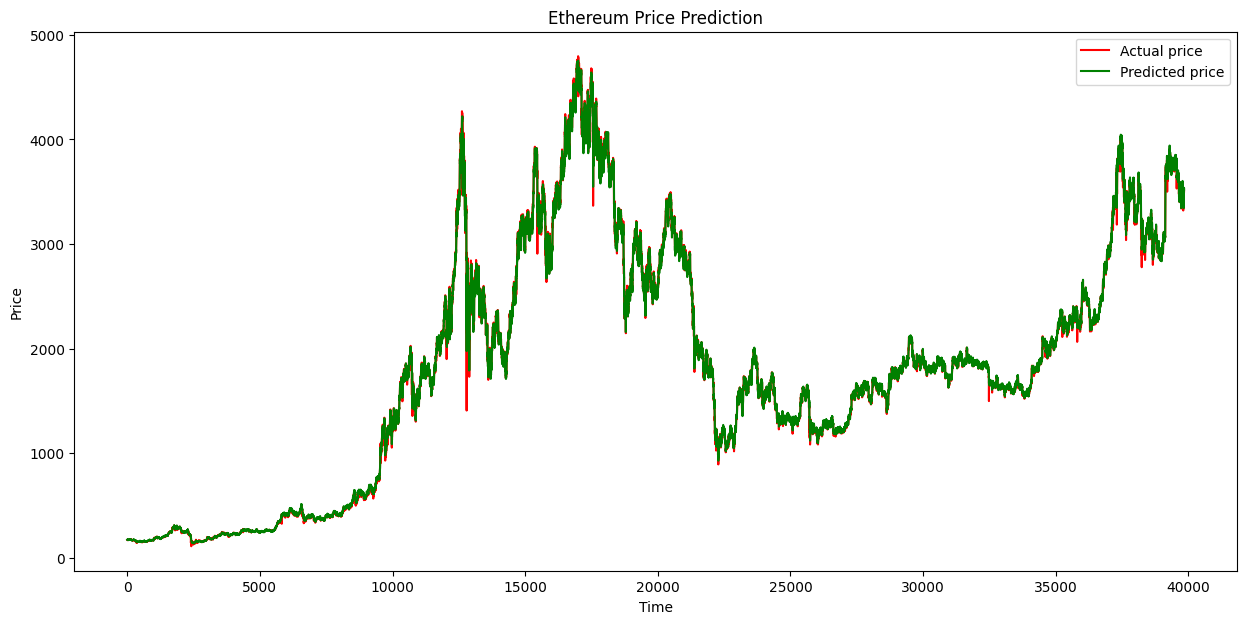

In [51]:
# Plot the predictions
plt.figure(figsize=(15, 7))
plt.plot(y_rescaled, color='red', label='Actual price')
plt.plot(predictions_rescaled, color='green', label='Predicted price')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [53]:
# Backtesting function
def backtest_strategy(data, predictions, initial_balance=1000):
    balance = initial_balance
    eth_holdings = 0
    balance_history = []

    for i in range(len(predictions)):
        if predictions[i] > data['close'].iloc[i]:
            # Buy signal
            if balance > 0:
                eth_holdings = balance / data['close'].iloc[i]
                balance = 0
        else:
            # Sell signal
            if eth_holdings > 0:
                balance = eth_holdings * data['close'].iloc[i]
                eth_holdings = 0
        balance_history.append(balance + eth_holdings * data['close'].iloc[i])

    return balance_history

In [54]:
# Backtest the strategy
balance_history = backtest_strategy(data.iloc[-len(predictions_rescaled):], predictions_rescaled)

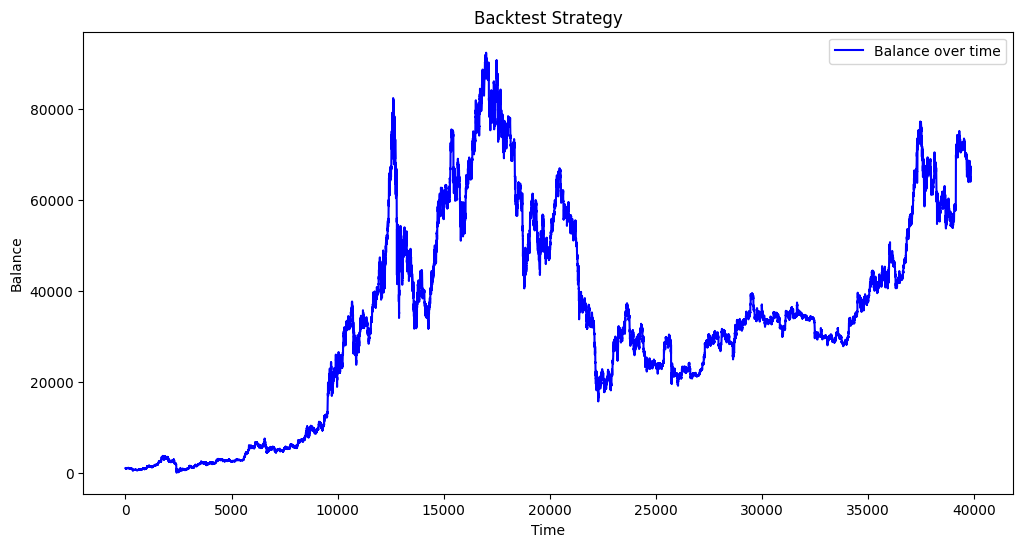

In [55]:
# Plot the backtest results
plt.figure(figsize=(12, 6))
plt.plot(balance_history, color='blue', label='Balance over time')
plt.title('Backtest Strategy')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.legend()
plt.show()